# Imports

In [ ]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.data.loader import load_prices, compute_returns
from src.optimization.markowitz import minimize_volatility
from src.optimization.sharpe import maximize_sharpe
from src.optimization.markowitz import minimize_volatility, portfolio_return, portfolio_volatility

import matplotlib.pyplot as plt



# User input

In [ ]:
target_return = 0.01
risk_free_rate = 0.15
tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA", "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "MGLU3.SA", "GGBR4.SA"] # PETR4, VALE3, ITUB4, BBDC4, BBAS3, ABEV3, WEGE3, B3SA3, MGLU3, GGBR4
start_date = "2019-01-01"
end_date = "2023-01-01"

# Levantando estatística dos dados

In [38]:
prices = load_prices(tickers, start=start_date, end=end_date)

c:\Users\leomc\OneDrive\Work\Unicap\Semestre 2025.2\TCC2\git\deep_learning_finance\src\data\loader.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  10 of 10 completed


In [39]:
daily_returns = compute_returns(prices)
# mean_returns = daily_returns.mean()
# cov_matrix = daily_returns.cov()

daily_returns = (1 + daily_returns).cumprod() - 1
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()


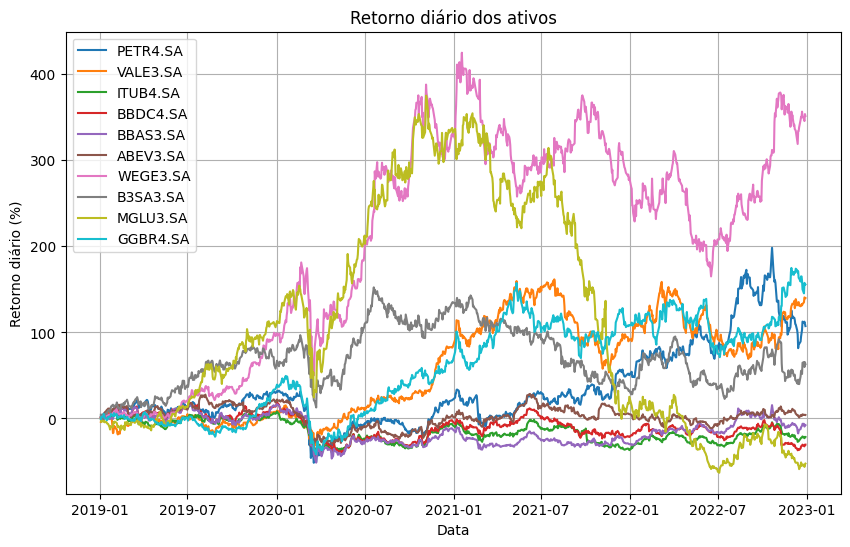

In [40]:
# fazer gráfico dos retorno diários acumulados
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(daily_returns.index, daily_returns[ticker] * 100, label=ticker)
plt.title("Retorno diário dos ativos")
plt.ylabel("Retorno diário (%)")
plt.xlabel("Data")
plt.legend(tickers)
plt.grid()
plt.show()

In [41]:
type(mean_returns)

pandas.core.series.Series

In [42]:
#print(daily_returns)
print("\n--------------------\n")
print(mean_returns)


--------------------

Ticker
ABEV3.SA    0.024920
B3SA3.SA    0.692644
BBAS3.SA   -0.136178
BBDC4.SA   -0.094901
GGBR4.SA    0.588653
ITUB4.SA   -0.158591
MGLU3.SA    1.107365
PETR4.SA    0.339281
VALE3.SA    0.588763
WEGE3.SA    2.069052
dtype: float64


In [43]:
cov_matrix

Ticker,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC4.SA,GGBR4.SA,ITUB4.SA,MGLU3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Ticker,,,,,,,,,,
ABEV3.SA,0.014456,-0.007928,0.011092,0.012630,0.008490,0.010499,-0.032815,0.012843,0.006885,-0.032291
B3SA3.SA,-0.007928,0.115024,-0.019981,-0.007547,0.033699,-0.003976,0.359793,-0.030768,0.050752,0.248949
BBAS3.SA,0.011092,-0.019981,0.023818,0.015057,-0.020862,0.013959,-0.110319,0.025802,-0.031520,-0.114163
BBDC4.SA,0.012630,-0.007547,0.015057,0.018686,-0.016233,0.014604,-0.019818,-0.002198,-0.014430,-0.086629
GGBR4.SA,0.008490,0.033699,-0.020862,-0.016233,0.304779,-0.020530,-0.007246,0.161135,0.298985,0.535752
ITUB4.SA,0.010499,-0.003976,0.013959,0.014604,-0.020530,0.014123,-0.013439,-0.002377,-0.019850,-0.076148
MGLU3.SA,-0.032815,0.359793,-0.110319,-0.019818,-0.007246,-0.013439,1.672474,-0.337782,0.089915,0.762351
PETR4.SA,0.012843,-0.030768,0.025802,-0.002198,0.161135,-0.002377,-0.337782,0.214853,0.134209,0.171095
VALE3.SA,0.006885,0.050752,-0.031520,-0.014430,0.298985,-0.019850,0.089915,0.134209,0.327554,0.555050


In [44]:
weights_markowitz = minimize_volatility(mean_returns, cov_matrix, target_return)




In [45]:
risk_free_rate_annual = 0.15
risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1/252) - 1

weights_sharpe = maximize_sharpe(mean_returns, cov_matrix, risk_free_rate=risk_free_rate_daily)

In [46]:
type(weights_markowitz)

numpy.ndarray

In [47]:
weights_markowitz

array([2.15231761e-01, 6.56153587e-02, 2.48064927e-01, 0.00000000e+00,
       0.00000000e+00, 4.32788555e-01, 6.91178885e-18, 7.15573434e-18,
       0.00000000e+00, 3.82993982e-02])

In [48]:
type(weights_sharpe)

numpy.ndarray

In [49]:
weights_sharpe

array([2.81583351e-01, 5.32152033e-01, 1.50252124e-16, 7.19828927e-16,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.79563584e-01,
       1.23978518e-16, 6.70103277e-03])

### Chart plot - Markowitz

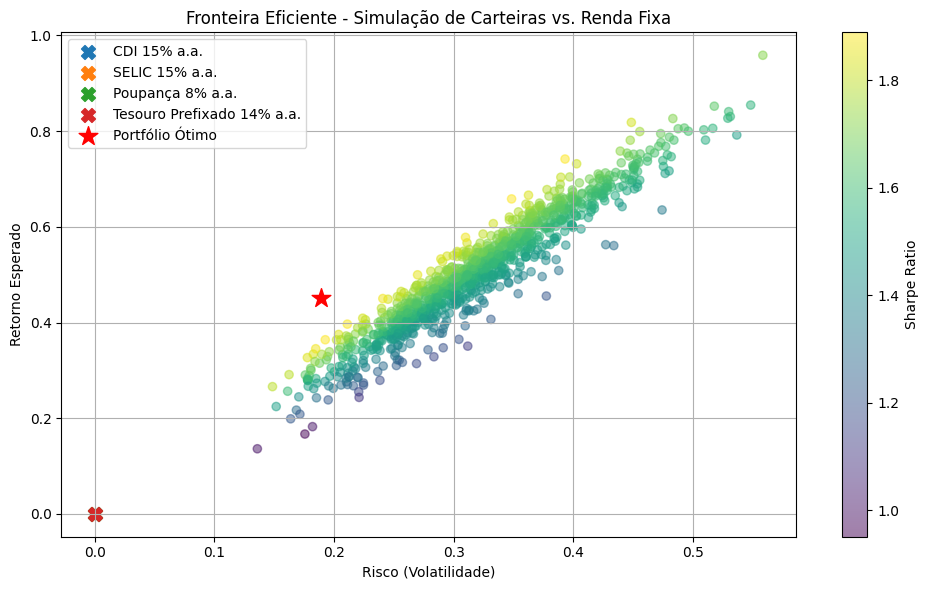

In [50]:
from outputs.charts.markowitz_plot import plot_efficient_frontier


plot_efficient_frontier(mean_returns, cov_matrix, optimized_weights=weights_sharpe) # esse mean_returns tem que ser (pd.Series)

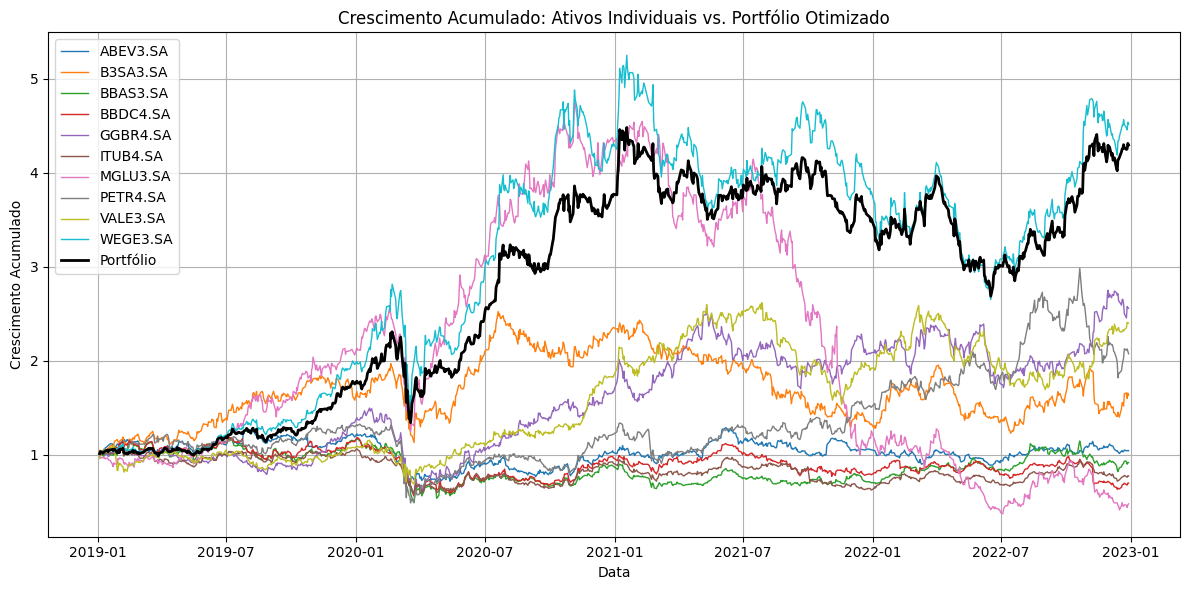

In [14]:
from outputs.charts.markowitz_plot import plot_time_serie


plot_time_serie(daily_returns, optimized_weights=weights_sharpe) # esse mean_returns tem que ser pd.DataFrame

In [15]:
import numpy as np

sharpe_individual = (mean_returns - risk_free_rate_daily) / np.sqrt(np.diag(cov_matrix))
print(sharpe_individual.sort_values(ascending=False))


Ticker
WEGE3.SA    0.050614
GGBR4.SA    0.028100
VALE3.SA    0.025713
PETR4.SA    0.021545
B3SA3.SA    0.011564
MGLU3.SA   -0.011656
BBAS3.SA   -0.011680
ABEV3.SA   -0.014349
BBDC4.SA   -0.025384
ITUB4.SA   -0.026044
dtype: float64


In [16]:
ret_sharpe = portfolio_return(weights_sharpe, mean_returns)
vol_sharpe = portfolio_volatility(weights_sharpe, cov_matrix)
sharpe_ratio = (ret_sharpe - risk_free_rate_daily) / vol_sharpe

print("Retorno:", ret_sharpe)
print("Volatilidade:", vol_sharpe)
print("Sharpe Ratio:", sharpe_ratio)


Retorno: 0.0017219790689187425
Volatilidade: 0.022339642839899795
Sharpe Ratio: 0.05224856860026463


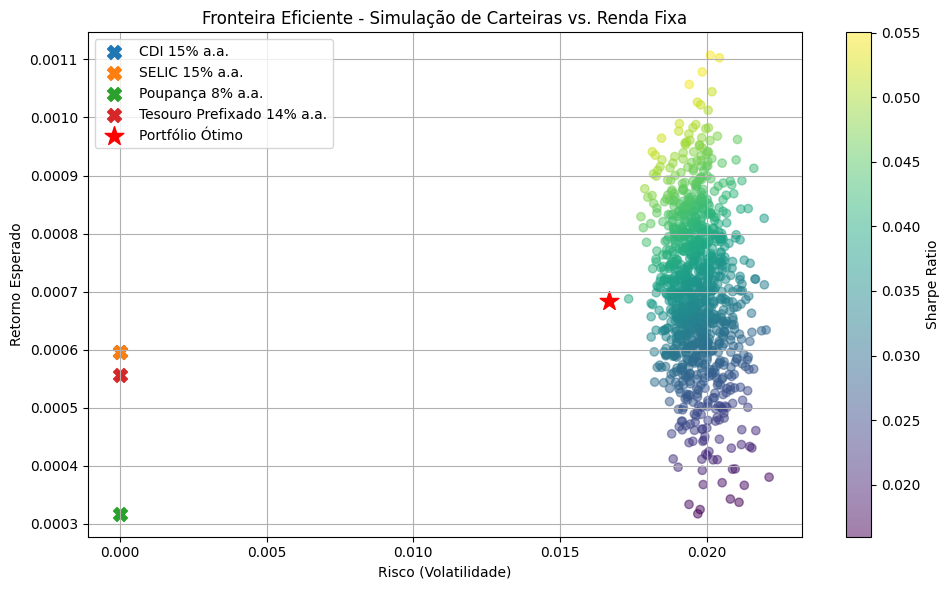

In [17]:

plot_efficient_frontier(mean_returns, cov_matrix, optimized_weights=weights_markowitz) # esse mean_returns tem que ser (pd.Series)


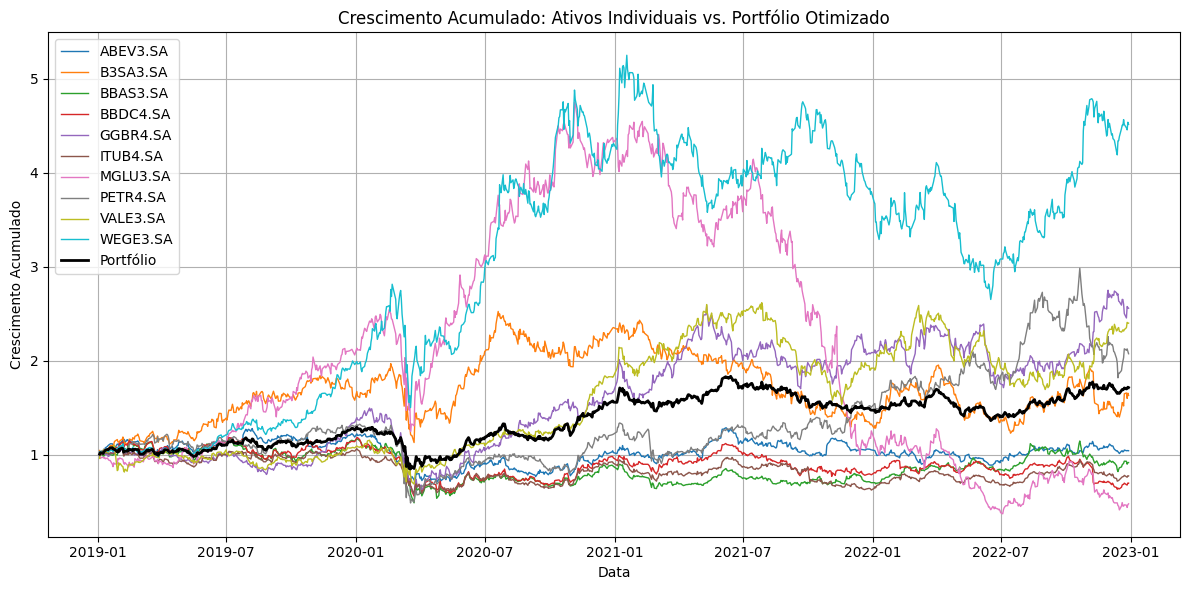

In [18]:
plot_time_serie(daily_returns, optimized_weights=weights_markowitz) # esse mean_returns tem que ser pd.DataFrame
